In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

seed = 142857
rng = np.random.default_rng(seed)
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, FrankCopula, ClaytonCopula)

torch.set_num_threads(8)
torch.set_default_tensor_type(torch.DoubleTensor)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

data = pd.read_csv("Steel_industry_theta_4_event_3.7853055000305176_1.132067084312439_censoring_3.406774950027466_1.132067084312439_eventrate_0.8512229230286252.csv")

observed_time = data['y'].values
covariates = data.iloc[:,0:18].values
event_indicator = data['event_indicator'].values

batch_size = 4096

In [ ]:
from torch.utils.data import TensorDataset, DataLoader

times_tensor = torch.tensor(observed_time, dtype=torch.float64).to(device)
event_indicator_tensor = torch.tensor(event_indicator, dtype=torch.float64).to(device)
covariate_tensor = torch.tensor(covariates, dtype=torch.float64).to(device)
train_data = TensorDataset(covariate_tensor[0:30000], times_tensor[0:30000], event_indicator_tensor[0:30000])
val_data = TensorDataset(covariate_tensor[30000:], times_tensor[30000:], event_indicator_tensor[30000:])

train_loader = DataLoader(train_data, batch_size= batch_size, shuffle=True)
val_loader = DataLoader(val_data, batch_size= batch_size, shuffle=True)

### Define Likelihood with ACNET copula

In [8]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import os, sys
sys.path.append(os.path.abspath('../'))

from dirac_phi import DiracPhi
from survival import SurvivalCopula
from survival import sample
num_epochs = 500000

# import wandb

# # start a new wandb run to track this script
# run = wandb.init(
#     # set the wandb project where this run will be logged
#     project="ACNet Survival",
#     # track hyperparameters and run metadata
#     config={
#     "dataset": "Semi-synthetic Clayton Copula Weibull Hazzards",
#     "epochs": 50000,
#     }
# )


# Early stopping
best_val_loglikelihood = float('-inf')
epochs_no_improve = 0
early_stop_epochs = 10000

# Parameters for ACNet 
depth = 2
widths = [10, 10]
lc_w_range = (0, 1.0)
shift_w_range = (0., 2.0)

phi = DiracPhi(depth, widths, lc_w_range, shift_w_range, device, tol = 1e-15).to(device)
model = SurvivalCopula(phi, device = device, num_features=18 , tol=1e-15).to(device)
# optimizer = get_optim(optim_name, net, optim_args)

optimizer_event = optim.Adam([{"params": [model.scale_t], "lr": 0.01},
                            {"params": [model.shape_t], "lr": 0.01},
                            {"params": model.net_t.parameters(), "lr": 0.01}])
optimizer_censoring = optim.Adam([{"params": [model.scale_c], "lr": 0.01},
                            {"params": [model.shape_c], "lr": 0.01},
                            {"params": model.net_c.parameters(), "lr": 0.01}])
optimizer_copula = optim.Adam([{"params": model.phi.parameters(), "lr": 0.01}])

train_loss_per_epoch = []
print("Start training!")
for epoch in range(num_epochs):
    loss_per_minibatch = []
    for i, (x , t, c) in enumerate(train_loader, 0):
        optimizer_copula.zero_grad()
        optimizer_event.zero_grad()
        optimizer_censoring.zero_grad()

        p = model(x, t, c, max_iter = 10000)
        logloss = -p
        logloss.backward() 
        scalar_loss = (logloss/p.numel()).detach().cpu().numpy().item()

        optimizer_censoring.step()
        optimizer_event.step()
        optimizer_copula.step()
        
        loss_per_minibatch.append(scalar_loss)
    train_loss_per_epoch.append(np.mean(loss_per_minibatch))
    if epoch % 100 == 0:
        print('Training loss at epoch %s: %.5f' %
                (epoch, train_loss_per_epoch[-1]))
        print(f"Shape Event: {model.shape_t.item(): .3f},\
            Shape Censoring: {model.shape_c.item(): .3f},\
            Scale Event: {model.scale_t.item(): .3f}, Scale Censoring: {model.scale_c.item(): .3f}")
    
        val_loglikelihoods = []
        for i, (x_val, t_val, c_val) in enumerate(val_loader, 0):
            p_val = model(x_val, t_val, c_val, max_iter = 10000)
            val_loglikelihood = p_val

        print('Validation log-likelihood at epoch %s: %s' % (epoch, val_loglikelihood.cpu().detach().numpy().item()))
    
        # Check if validation loglikelihood has improved
        if val_loglikelihood > best_val_loglikelihood:
            best_val_loglikelihood = val_loglikelihood
            epochs_no_improve = 0
            torch.save({
            'epoch': epoch,
            'model_state_dict': model.state_dict(),
            'loss': best_val_loglikelihood,
            }, 'checkpoint_steel.pth')
        else:
            epochs_no_improve += 100

        # Early stopping condition
        if epochs_no_improve == early_stop_epochs:
            print('Early stopping triggered at epoch: %s' % epoch)
            break
    # Plot Samples from the learned copula
    if epoch % 1000 == 0:
        print('Scatter sampling')
        samples = sample(model, 2, 10000, device =  device)
        plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu())
        plt.savefig('./sample_figs/epoch%s.png' %
                    (epoch))
        plt.clf()
    
    # wandb.log({"log_likelihood": p, 
    #             "event_shape": model.shape_t.item(), "censoring_shape": model.shape_c.item(), \
    #             "event_scale": model.scale_t.item(), "censoring_scale": model.scale_c.item()})

Start training!
Training loss at epoch 0: 99148.37912
Shape Event:  0.933,            Shape Censoring:  0.925,            Scale Event:  1.067, Scale Censoring:  1.073
Validation log-likelihood at epoch 0: -9284.30958886043
Scatter sampling
Sampling from dim: 1
Training loss at epoch 100: 13401.79869
Shape Event:  1.279,            Shape Censoring:  1.486,            Scale Event:  1.135, Scale Censoring:  1.226
Validation log-likelihood at epoch 100: -3352.07954503173
Training loss at epoch 200: 12261.16423
Shape Event:  1.850,            Shape Censoring:  2.223,            Scale Event:  1.140, Scale Censoring:  1.242
Validation log-likelihood at epoch 200: -3166.301141316815
Training loss at epoch 300: 11581.49399
Shape Event:  2.433,            Shape Censoring:  2.806,            Scale Event:  1.147, Scale Censoring:  1.262
Validation log-likelihood at epoch 300: -3178.1743641077737
Training loss at epoch 400: 11199.38677
Shape Event:  2.991,            Shape Censoring:  3.216,       

<Figure size 640x480 with 0 Axes>

### Plotting

/home/weijia/anaconda3/lib/python3.10/site-packages/statsmodels/tools/rng_qrng.py:54: FutureWarning: Passing `None` as the seed currently return the NumPy singleton RandomState
(np.random.mtrand._rand). After release 0.13 this will change to using the
default generator provided by NumPy (np.random.default_rng()). If you need
reproducible draws, you should pass a seeded np.random.Generator, e.g.,

import numpy as np
seed = 32839283923801
rng = np.random.default_rng(seed)"

  warnings.warn(_future_warn, FutureWarning)


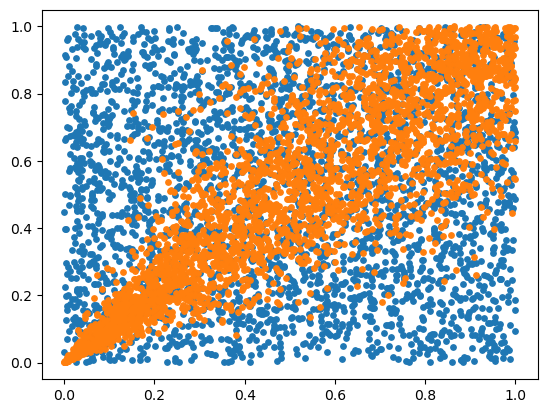

In [7]:
# Scatter Plot
checkpoint = torch.load('checkpoint_steel.pth')
model.load_state_dict(checkpoint['model_state_dict'])
samples =  sample(model, 2, 3000, device =  device)
plt.scatter(samples[:, 0].cpu(), samples[:, 1].cpu(), s = 15)
# plt.savefig('./sample_figs/clayton/best_epoch_clayton_10.png')
# plt.clf()

# plotting with known copula
known_copula = ClaytonCopula(4, k_dim=2)
samples_known = known_copula.rvs(3000)
plt.scatter(samples_known[:, 0], samples_known[:, 1], s = 15)
# plt.savefig('./sample_figs/clayton/best_true_sample_clayton_10.png')
# plt.clf()


#### Joint Distribution (Cumulative Distribution Function) Spectral Plot

In [ ]:
# learned model
n = 500
x1 = np.linspace(0.001, 1, n)
x2 = np.linspace(0.001, 1, n)
xv1, xv2 = np.meshgrid(x1, x2)
xv1_tensor = torch.tensor(xv1.flatten()).to(device)
xv2_tensor = torch.tensor(xv2.flatten()).to(device)
query = torch.stack((xv1_tensor, xv2_tensor)
                    ).double().t().requires_grad_(True)
cdf = model.cond_cdf(query, mode='cdf')
pdf = model.cond_cdf(query, mode='pdf')

heat_cdf = cdf.reshape(n,n).cpu().detach().numpy()
heat_pdf = pdf.reshape(n,n).cpu().detach().numpy()

# Create filled contour plot
plt.contourf(x1, x2, heat_cdf, 200, cmap='Spectral_r')
# Add a colorbar
# plt.colorbar(label='Cumulative Distribution Function')
# Show the plot
plt.savefig('Clayton_Learned_CDF_10.png', dpi=300)

plt.clf()
# Create filled contour plot
plt.contourf(x1, x2, np.log(heat_pdf), 500, cmap='Spectral_r')
# Add a colorbar
# plt.colorbar(label='Log Density Function')
# Show the plot
plt.savefig('Clayton_Learned_LogPDF_10.png', dpi=300)


In [ ]:
# Known copula
from statsmodels.distributions.copula.api import (
    CopulaDistribution, GumbelCopula, FrankCopula, ClaytonCopula)

n = 1000
x1 = np.linspace(0.001, 1, n)
x2 = np.linspace(0.001, 1, n)
xv1, xv2 = np.meshgrid(x1, x2)
xv1_tensor = torch.tensor(xv1.flatten())
xv2_tensor = torch.tensor(xv2.flatten())
query = torch.stack((xv1_tensor, xv2_tensor)
                    ).t().numpy()
print(query.shape)

known_copula = ClaytonCopula(theta=theta, k_dim=2)
heat_cdf = known_copula.cdf(u=query).reshape(n,n)
heat_pdf = known_copula.pdf(u=query).reshape(n,n)

# Create filled contour plot
plt.contourf(x1, x2, heat_cdf, 200, cmap='Spectral_r')
plt.tick_params(axis='both', direction='in', length=4, width=1)
# Add a colorbar
# plt.colorbar(label='Cumulative Distribution Function')
# Show the plot
# plt.show()
plt.savefig('Clayton_Known_CDF_10.png', dpi=300)

plt.clf()
# Create filled contour plot
plt.contourf(x1, x2, np.log(heat_pdf), 200, cmap='Spectral_r')
plt.tick_params(axis='both', direction='in', length=4, width=1)
# Add a colorbar
# plt.colorbar(label='Log Density Function')
# Show the plot
# plt.show()
plt.savefig('Clayton_Known_LogPDF_10.png', dpi=300)